In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,Dropout,MaxPooling2D,Attention,Conv2D,concatenate

from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import Xception,VGG16,VGG19,MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
train_path="/kaggle/input/deepfake-dataset-merged/train"
test_path="/kaggle/input/deepfake-dataset-merged/test"
val_path="/kaggle/input/deepfake-dataset-merged/valid"

#train_path="/kaggle/input/autism-data/AutismDataset/train"
#test_path="/kaggle/input/autism-data/AutismDataset/test"
#val_path="/kaggle/input/autism-data/AutismDataset/valid"
train_datagen = ImageDataGenerator( 
                                   rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  ) 
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(  rescale=1./255.0)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'binary',
                                            shuffle=False)
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'binary')

Found 248002 images belonging to 2 classes.
Found 31905 images belonging to 2 classes.
Found 60428 images belonging to 2 classes.


In [4]:
base_model = MobileNet(input_shape=(224,224,3),weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [5]:
for layer in base_model.layers:
  layer.trainable=False
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.summary()
#plot_model(model)
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [6]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
#Defining a Checkpoint
checkpoint = ModelCheckpoint(filepath = 'mobilenet.h5',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True,
                            verbose = 1)

#Defining a Early Stopping
earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta = .5,
                         patience = 5,
                         restore_best_weights = True)

#Defining LR Reducing rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.01,
                             patience = 5,
                             verbose = 1,
                             min_delta = 0.5)

#Putting the call backs in a callback list
#callbacks = [checkpoint, reduce_lr]
callbacks = [checkpoint,earlystop]

In [7]:
history = model.fit(
    training_set,
    epochs=10,
    batch_size=32,
    validation_data=val_set,
    callbacks=[callbacks]
)

Epoch 1/10
3876/3876 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.7542
Epoch 1: val_accuracy improved from -inf to 0.80339, saving model to mobilenet.h5
3876/3876 [==============================] - 5099s 1s/step - loss: 0.4995 - accuracy: 0.7542 - val_loss: 0.4191 - val_accuracy: 0.8034
Epoch 2/10
3876/3876 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.7967
Epoch 2: val_accuracy improved from 0.80339 to 0.80855, saving model to mobilenet.h5
3876/3876 [==============================] - 3260s 841ms/step - loss: 0.4387 - accuracy: 0.7967 - val_loss: 0.4150 - val_accuracy: 0.8085
Epoch 3/10
3876/3876 [==============================] - ETA: 0s - loss: 0.4183 - accuracy: 0.8087
Epoch 3: val_accuracy improved from 0.80855 to 0.83595, saving model to mobilenet.h5
3876/3876 [==============================] - 3349s 864ms/step - loss: 0.4183 - accuracy: 0.8087 - val_loss: 0.3653 - val_accuracy: 0.8360
Epoch 4/10
3876/3876 [=====================

In [8]:
def plot_training(hist):
    """
    visualize the training and validation performance of a machine learning model over epochs. 
    It plots two subplots
    1.training and validation loss 
    2. training and validation accuracy, 
    highlighting the epochs with the lowest validation loss and the highest validation accuracy
    """
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

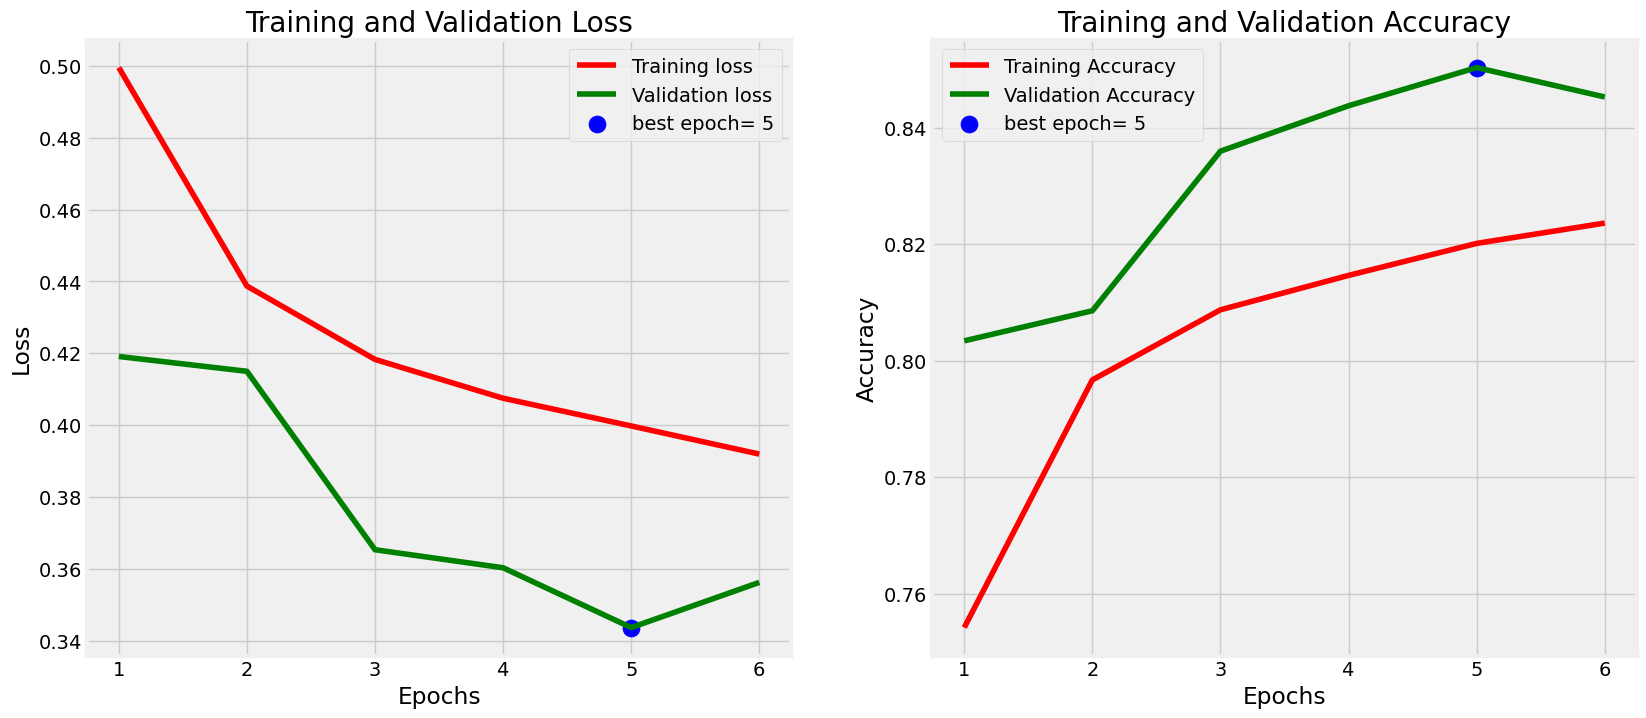

In [9]:
plot_training(history)

In [10]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

num_test_sample=len(test_set)
num_classes=len(test_set.class_indices)

predicted_probabilities=model.predict(test_set,steps=num_test_sample)
predicted_labels=np.argmax(predicted_probabilities,axis=1)

true_labels=test_set.classes

report=classification_report(true_labels,predicted_labels)
print(report)

499/499 [==============================] - 173s 345ms/step
              precision    recall  f1-score   support

           0       0.83      0.72      0.77     16492
           1       0.74      0.84      0.79     15413

    accuracy                           0.78     31905
   macro avg       0.78      0.78      0.78     31905
weighted avg       0.78      0.78      0.78     31905

